## Loading the Dataset and Preprocessing

In [ ]:
pip install medmnist

In [ ]:
import medmnist
print(medmnist.__version__)
from medmnist import PathMNIST
from medmnist import INFO
print(INFO['pathmnist'])

3.0.2


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import models, datasets
import torchvision
import torchvision.datasets as DS
from torch.utils.data import ConcatDataset, random_split, DataLoader

from PIL import Image
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from torchvision.models import vgg16

In [ ]:
#LOADING TEST PathMNIST DATASET to test our VGG16 Model of PathMNIST with GRADCAM

data_transform = transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomRotation((90, 90)),
        transforms.RandomRotation((180, 180)),
        transforms.RandomRotation((270, 270))
    ]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = PathMNIST(split="test", download=True, transform=data_transform, size=224)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 12.6G/12.6G [11:44<00:00, 17.9MB/s]


In [ ]:
def imshow(img):
    # remove the impact of normalization
    img = img / 2 + 0.5
    npimg = img.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
#LOADING VGG16 TRAINED CNN MODEL to test our VGG16 Model of PathMNIST with GRADCAM

model = vgg16(pretrained=False)
model.classifier[6] = torch.nn.Linear(4096, 9)  # Match architecture
model.load_state_dict(torch.load("best_vgg16_multiclass_dec2.pth"))
model.eval()

Confusion Matrix:
[[1268    2    1    0   21   46    0    0    0]
 [   0  847    0    0    0    0    0    0    0]
 [   0    2  328    6    0    2    0    0    1]
 [   0    0    0  634    0    0    0    0    0]
 [   0    1    0    0 1033    0    0    0    1]
 [   0   53    8    0    0  510    0   21    0]
 [   0    0    0   39    6    1  687    2    6]
 [   0    5   24    2    0   53    1  327    9]
 [   1    2    6    8   10    2   21    4 1179]]


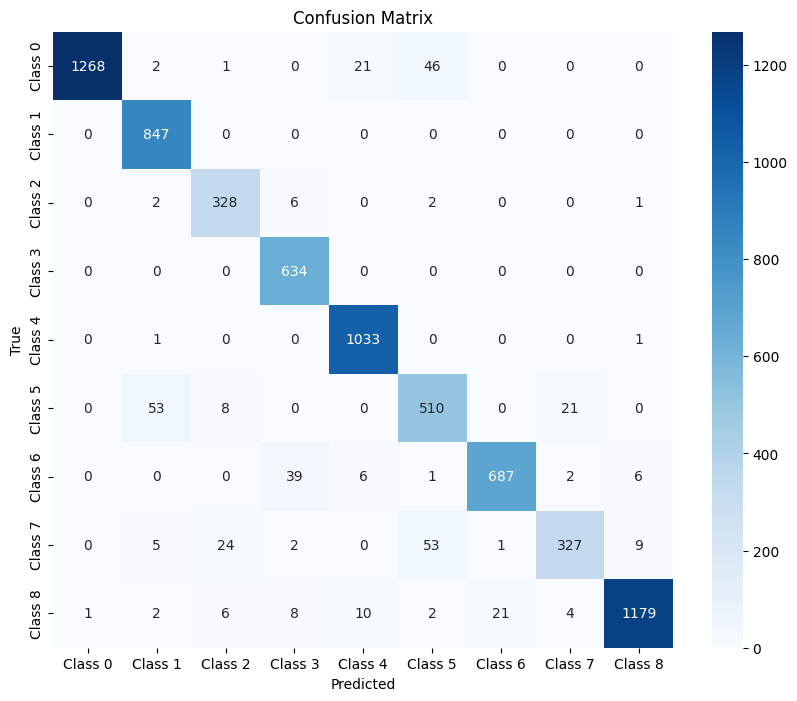

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97      1338
     Class 1       0.93      1.00      0.96       847
     Class 2       0.89      0.97      0.93       339
     Class 3       0.92      1.00      0.96       634
     Class 4       0.97      1.00      0.98      1035
     Class 5       0.83      0.86      0.85       592
     Class 6       0.97      0.93      0.95       741
     Class 7       0.92      0.78      0.84       421
     Class 8       0.99      0.96      0.97      1233

    accuracy                           0.95      7180
   macro avg       0.94      0.94      0.93      7180
weighted avg       0.95      0.95      0.95      7180



In [ ]:
#SANITY CHECK: LOADED MODEL is correct.

# Initialize storage for predictions and labels
all_preds = []
all_labels = []

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to the device

# Collect predictions and true labels
with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    for images, labels in test_loader:  # Iterate through test data
        images, labels = images.to(device), labels.to(device)  # Move to device

        logits = model(images)  # Forward pass
        probs = torch.softmax(logits, dim=1)  # Apply softmax for multi-class probabilities
        preds = torch.argmax(probs, dim=1)  # Get class with highest probability

        all_preds.extend(preds.cpu().numpy())  # Move to CPU for storage
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Define class names for PathMNIST
class_names = [f"Class {i}" for i in range(9)]

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


In [ ]:
#refernce: https://medium.com/@bmuskan007/grad-cam-a-beginners-guide-adf68e80f4bb


# selecting layers from the model to generate activations
image_to_heatmaps = nn.Sequential(*list(model.features[:-4]))  #-> SELECT LAYER HERE !!!

def compute_heatmap(model,img):
  model.eval()
  # compute logits from the model
  logits = model(img)
  # model's prediction
  pred = logits.max(-1)[-1]
  # activations from the model
  activations = image_to_heatmaps(img)
  # compute gradients with respect to the model's most confident prediction
  logits[0, pred].backward(retain_graph=True)
  # average gradients of the featuremap
  pool_grads = model.features[-3].weight.grad.data.mean((0,2,3))
  # multiply each activation map with corresponding gradient average
  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pool_grads[i]
  # calculate mean of weighted activations
  heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
  return heatmap, pred

def upsampleHeatmap(map, image):
  # permute image
  image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
  # maximum and minimum value from heatmap
  m, M = map.min(), map.max()
  # normalize the heatmap
  map = 255 * ((map-m)/ (m-M))
  map = np.uint8(map)
  # resize the heatmap to the same as the input
  map = cv2.resize(map, (224, 224))
  map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
  map = np.uint8(map)
  # change this to balance between heatmap and image
  map = np.uint8(map*0.7 + image*0.3)
  return map

In [ ]:
def display_images(upsampled_map, image):
    image = image.squeeze(0).permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(upsampled_map)
    axes[0].set_title("Heatmap")
    axes[0].axis('off')
    axes[1].imshow(image)
    axes[1].set_title("Original Image")
    axes[1].axis('off')
    plt.show()

Prediction: 4
Actual Label: [4]


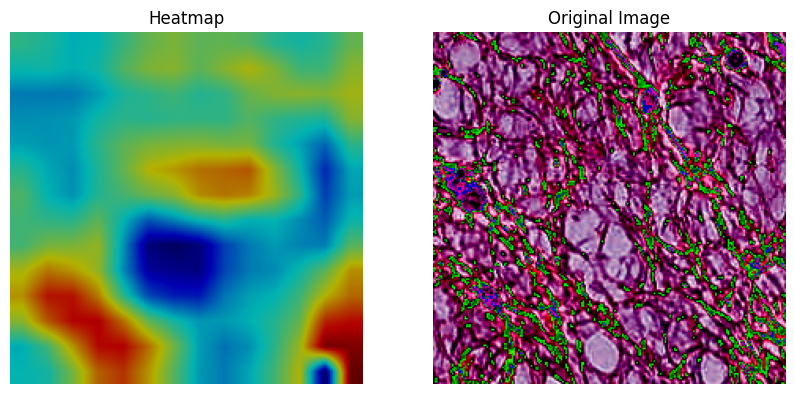

Prediction: 1
Actual Label: [4]


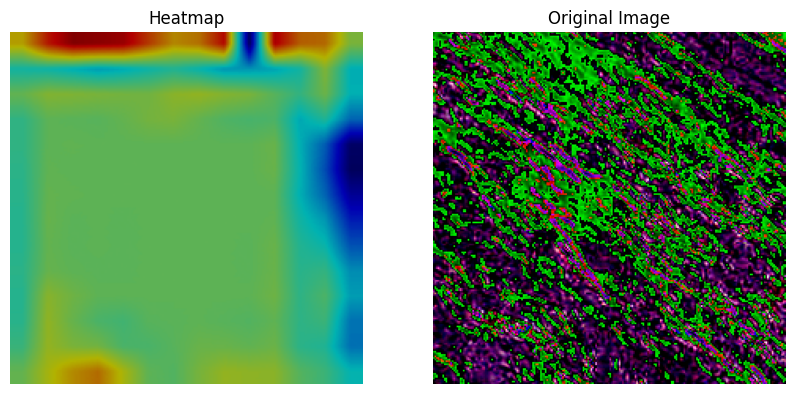

Prediction: 1
Actual Label: [4]


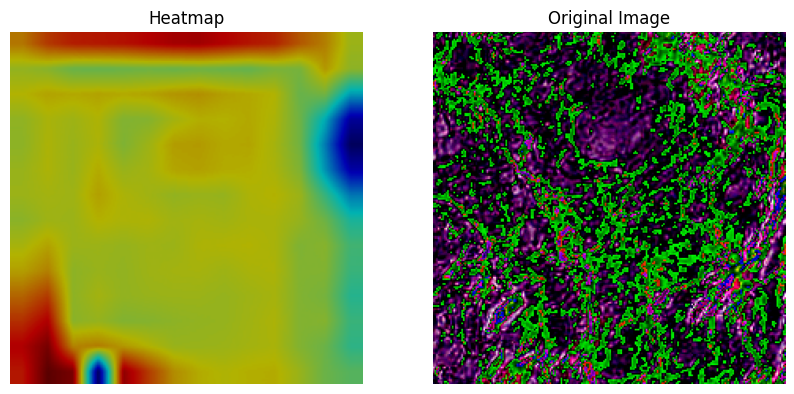

Prediction: 0
Actual Label: [0]


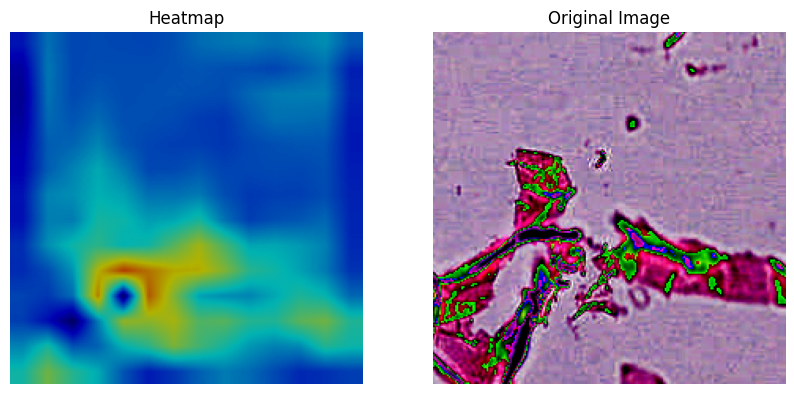

Prediction: 2
Actual Label: [8]


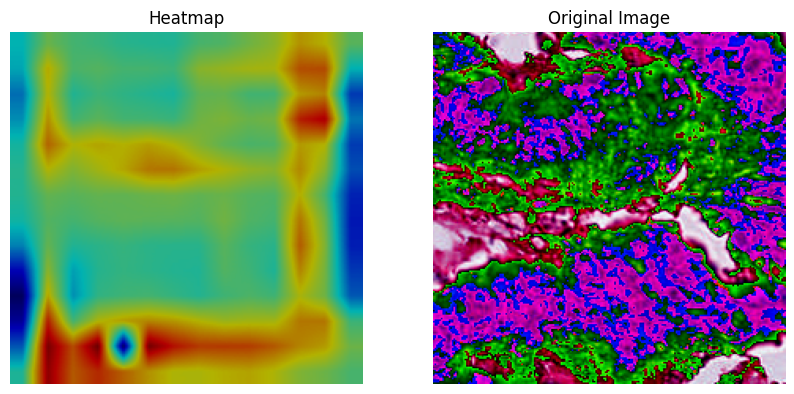

Prediction: 2
Actual Label: [3]


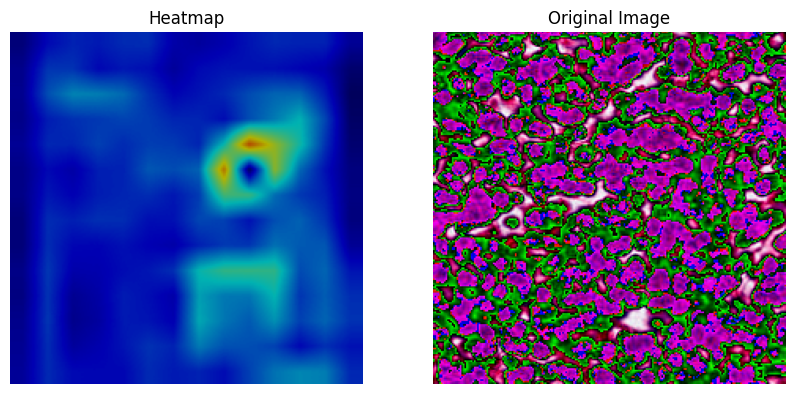

Prediction: 4
Actual Label: [4]


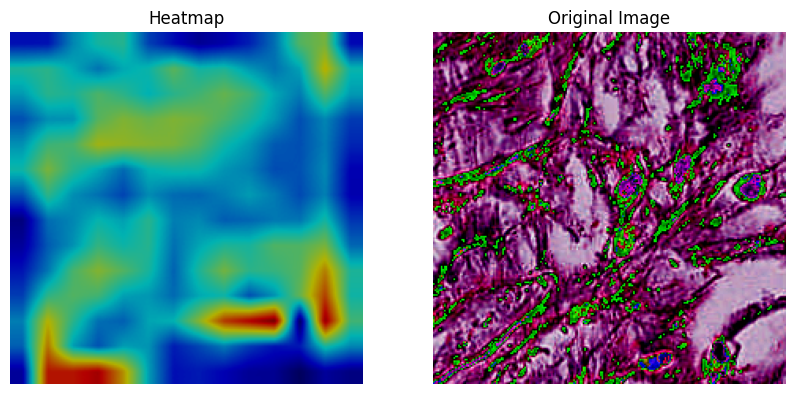

Prediction: 0
Actual Label: [0]


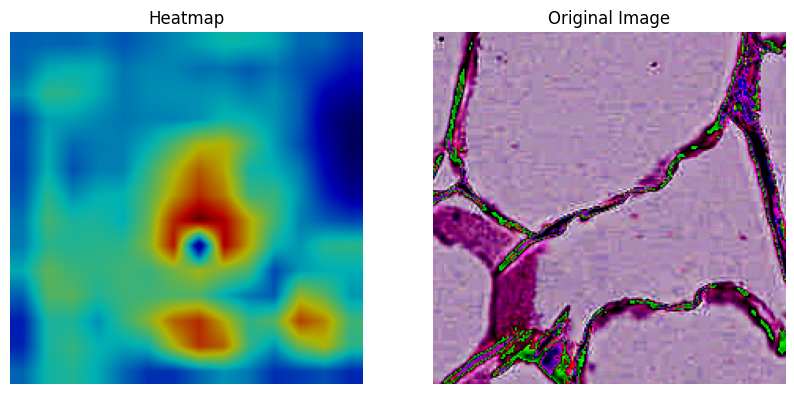

Prediction: 1
Actual Label: [7]


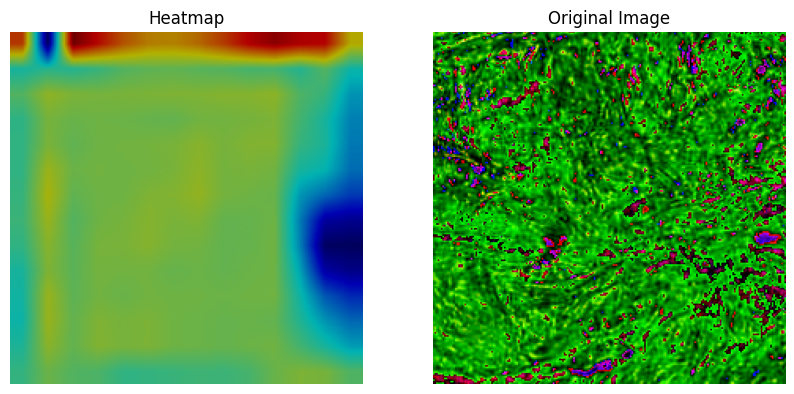

Prediction: 7
Actual Label: [4]


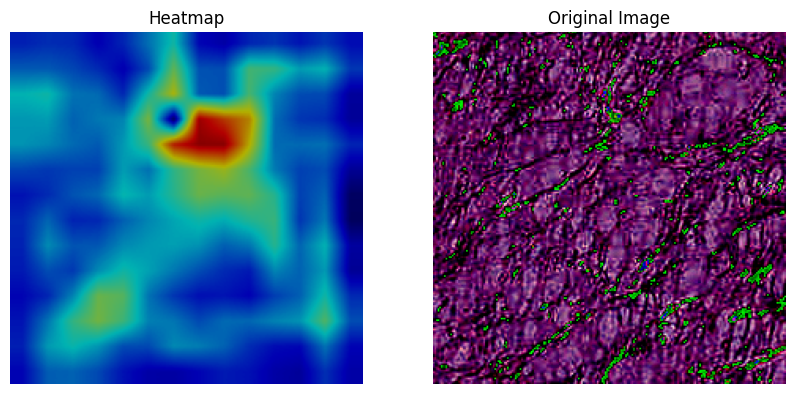

Prediction: 0
Actual Label: [0]


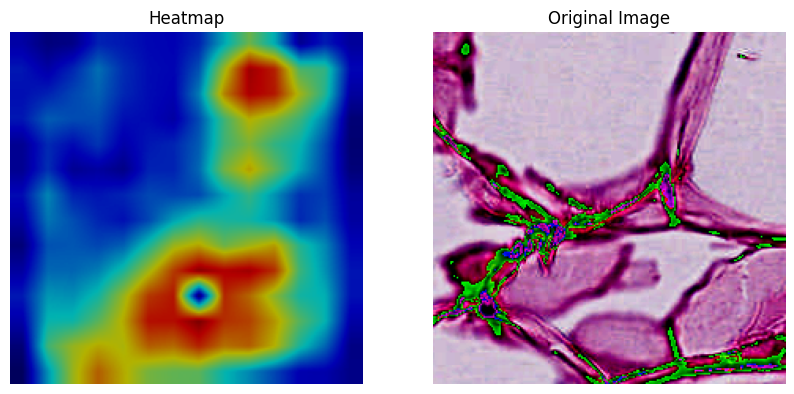

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Ensure the model is on the correct device

for i in range(60, 71):  # Iterate over selected samples
    sel_image, sel_label = test_dataset[i]  # Get image and label from the dataset

    # Convert to PIL Image and preprocess
    sel_image_pil = transforms.ToPILImage()(sel_image)
    input_tensor = data_transform(sel_image_pil).unsqueeze(0).to(device)  # Move to GPU

    # Compute heatmap and predictions
    heatmap, pred = compute_heatmap(model, input_tensor)  # Ensure output is PyTorch tensors
    upsampled_map = upsampleHeatmap(heatmap, input_tensor)  # Also ensure this returns tensors

    # Move prediction and label to CPU for printing
    pred_cpu = pred.cpu().item() if isinstance(pred, torch.Tensor) else pred  # Convert tensor to scalar
    sel_label_cpu = (
        sel_label if isinstance(sel_label, int)
        else sel_label.cpu().item() if isinstance(sel_label, torch.Tensor)
        else sel_label
    )

    print(f"Prediction: {pred_cpu}")
    print(f"Actual Label: {sel_label_cpu}")

    # Visualize (ensure inputs to display_images are appropriate)
    if isinstance(upsampled_map, torch.Tensor):
        upsampled_map = upsampled_map.cpu()  # Move to CPU if tensor
    if isinstance(input_tensor, torch.Tensor):
        input_tensor = input_tensor.cpu()  # Move to CPU if tensor

    display_images(upsampled_map, input_tensor)
